In [1]:
import numpy as np
import h5py
import pylab as pl
import arrayfire as af
from scipy.integrate import odeint
import scipy.fftpack as ff
from scipy import interpolate

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [3]:
def periodic_particles(positions_x, length_domain_x):
    '''
    function periodic_particles(positions_x, length_domain_x)
    -----------------------------------------------------------------------
    Input variables: positions_x and length_domain_x

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code. 
        It contains the positions of particles.

        length_domain_x: This is the length of the domain. The domain is assumed to be from x = 0 
        to x = length_domain_x 

    -----------------------------------------------------------------------    
    returns: positions_x
        This function returns the modified positions_x such that particle previously gone outside the domain 
        through the left boundary enter via the right boundary and vice versa.
        In other words, the function implements periodic boundary conditions for the particles. 

    '''
    
    # Determine indices of particles which have gone outside the domain
    # through left boundary
    outside_domain = np.where([positions_x < 0])[1]

    # Apply periodic boundary conditions
    
    positions_x[outside_domain] = positions_x[outside_domain] + length_domain_x

    # Determine indices of particles which have gone outside the domain
    # through right boundary
    
    outside_domain = np.where([positions_x > length_domain_x])[1]

    # Apply periodic boundary conditions
    
    positions_x[outside_domain] = positions_x[outside_domain] - length_domain_x
    
    return positions_x


In [4]:
def find_zone_and_fraction(positions_x, x_grid, dx):
    '''
    function find_zone_and_fraction(positions_x, x_grid, dx)
    -----------------------------------------------------------------------  
    Input variables: positions_x, x_grid, dx

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code. It contains
        the positions of particles.

        x_grid: This is the grid in position space.

        dx: This is distance between any two consecutive grid nodes of the position grid(x_grid).
    -----------------------------------------------------------------------      
    returns: zone_x, frac_x
        This function returns the arrays zone_x and frac_x

        zone_x: This is the array of size (number of macro particles) containing the indices of the left corners 
        of the grid cells containing the particles.

        frac_x: This is the array of size (number of macro particles) containing the fraction of the 
        grid cell where the particle is located. For example if the particles position is 0.3 
        between grid nodes(position grid) located at 0.2 and 0.4. frac_x is 0.5.
    -----------------------------------------------------------------------  
    Example: 
        Consider a grid: x_grid = [0, 0.2, 0.4, 0.6, 1.0] with dx = 0.2, and two particles with 
        positions_x = [0.15, 0.3]

        find_zone_and_fraction(positions_x, x_grid, dx)
        returns 
        zone_x = [0, 1], frac_x = [0.75, 0.5]
    '''    
    zone_x = np.floor((((positions_x ) - x_grid[0]) / dx))
    
    zone_x = zone_x.astype(np.int)
    
    frac_x = (positions_x - x_grid[zone_x]) / (dx)
    
    return zone_x, frac_x

## cloud in cell charge deposition: 
\begin{align}
\implies  \rho(\mathbf{x_{i}}, t) &= \frac{1 }{\Delta x}w_{p}q \sum_{p = 1}^{N} b_{1}\left(\frac{x_{p} - \mathbf{x_{i}}}{\Delta x}\right) 
\end{align}

In [5]:
# b1 charge depositor
def cloud_charge_deposition(charge, zone_x, frac_x, x_grid, dx):
    '''
    function cloud_charge_deposition(charge, zone_x, frac_x, x_grid, dx)
    -----------------------------------------------------------------------  
    Input variables: charge, zone_x, frac_x, x_grid, dx

        charge: This is a scalar denoting the charge of the macro particle in the PIC code.

        zone_x: This is an array of size (number of electrons/macro particles) containing the indices 
        of the left corners of the grid cells containing the respective particles

        frac_x: This is an array of size (number of electrons/macro particles) containing the fractional values of 
        the positions of particles in their respective grid cells. This is used for linear interpolation

        x_grid: This is an array denoting the position grid chosen in the PIC simulation

        dx: This is the distance between any two consecutive grid nodes of the position grid.

    -----------------------------------------------------------------------  
    returns: rho
         rho: This is an array containing the charges deposited at the density grid nodes.
    '''
    
    # Assigning particle charge to left grid point according to linear weighting scheme
    # or also known as b1 spline deposition
    left_corner_charge  = (1 - frac_x) * charge / (dx)
    
    # Assigning particle charge to right grid point
    right_corner_charge = (frac_x) * charge / (dx)

    
    # Storing the respective indices of left and right grid points
    left_corners  = zone_x.copy()
    right_corners = left_corners + 1

    
    # Joining the indices and charges into one vector each
    corners = np.concatenate([left_corners, right_corners], axis=0)
    charges = np.concatenate([left_corner_charge, right_corner_charge], axis=0)

    # Charge deposition using numpy histogram in a vectorized manner
    
    rho_electrons, temp = np.histogram(corners, bins=len(x_grid),\
                                       range=(0, len(x_grid)), \
                                       weights=charges\
                                      )
    
    # Applying periodic BC's for charge depostions from last and first zone since 
    # first and the last x_grid point are the same point according to periodic BC's
    # Since first and last point are the same, charge being deposited on the last grid point
    # must also be deposited on the first grid point
    
    rho_electrons[0]  = rho_electrons[0] + rho_electrons[-1]
    rho_electrons[-1] = rho_electrons[0].copy()
    
    return rho_electrons

The charge density is computed using the normalization factor $A$ given by :
\begin{align}
f_{pic} &= f_{a}  \\
\implies A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int f_{pic}\;dv\;dx}  \\
A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int\sum_{p=1}^{N_{m}} w_{p}S(x, x_{p})S(v, v_{x,p})\;dv\;dx} \\
A &= \frac{\int \int f_{a}\;dv\;dx}{N_{m} * w_{p}}
\end{align}
Background ion density is added to the computed charge density array:
\begin{align}
\int_{x_{i - \frac{1}{2}}}^{x_{i + \frac{1}{2}}} S(x, x_{p})dx &= b_{0+1}(\frac{\mathbf{x_{i}}- x_{p}}{\Delta x}) \\
\implies  \rho(\mathbf{x_{i}}, t) &= \frac{1 }{\Delta x}Aw_{p}q \sum_{p = 1}^{N} b_{1}\left(\frac{x_{p} - \mathbf{x_{i}}}{\Delta x}\right) + \rho_{ions}
\end{align}

In [6]:
def norm_background_ions(rho_electrons, number_of_electrons, w_p):
    '''
    function norm_background_ions(rho_electrons, number_of_electrons)
    -----------------------------------------------------------------------  
    Input variables: rho_electrons, number_of_electrons
        rho_electrons: This is an array containing the charges deposited at the density grid nodes.

        number_of_electrons: A scalar denoting the number of macro particles/electrons taken in the simulation
    -----------------------------------------------------------------------      
    returns: rho_normalized
        This function returns a array denoting the normalized charge density throughout the domain containing
        the contribution due background ions

    '''
    A                        = 1/(number_of_electrons * w_p)
    rho_electrons_normalized = A*rho_electrons
    
    # Adding background ion density, and ensuring charge neutrality
    rho_ions_normalized      = - np.sum(rho_electrons_normalized) / len(rho_electrons_normalized)
    
    rho_normalized           = rho_electrons_normalized + rho_ions_normalized
    
    return rho_normalized



\begin{align}
\hat{V}(k) &= \int_{0}^{1} potential(x)e^{-2\pi\;i\;k\;x}dx \\ \\
potential(x) &= \frac{1}{Npoints}\int_{0}^{1} \hat{potential}(k)e^{+2\pi\;i\;k\;x}dk \\ \\
\hat{potential}(k) &= \frac{1}{4\pi^{2}\;k^2}\hat{\rho(k)} \\ \\
\hat{E}(k) &= -i(2\pi\;k)\hat{potential}(k)
\end{align}

In [7]:
# FFT solver :
def fft_poisson(rho, dx):
    '''
    function fft_poisson(rho, dx)
    -----------------------------------------------------------------------  
    Input variables: rho, dx

        rho: This is an array containing the charges deposited at the density grid nodes.

        dx: This is the distance between any two consecutive grid nodes of the position grid.

    -----------------------------------------------------------------------  
    returns: potential, E

        potential: This is an array containing the potential values across the domain

        E: This is an array containing the electric field values across the domain.

    '''
    
    rho_temp      = rho[:-1]
    k_x           = ff.fftfreq(len(rho_temp), d = dx)
    rho_hat       = ff.fft(rho_temp)
    potential_hat = np.zeros(len(rho_temp))
    
    potential_hat[1:] =  (1/(4 * np.pi**2 * k_x[1:]**2)) * rho_hat[1:]
    potential_hat[0]  =  0
    
    E_hat =  -1j * 2 * np.pi * k_x * potential_hat
    
    potential = ff.ifft(potential_hat)
    potential = np.append(potential,potential[0])
    potential = (potential.real).astype(np.double)
    
    E = ff.ifft(E_hat)
    E = np.append(E,E[0])
    E = (E.real).astype(np.double)
    
    return potential, E

In [8]:
def set_up_perturbation(positions_x, number_particles, N_divisions,\
                        amplitude , k_x, length_domain_x, dx\
                       ):
    '''
    function set_up_perturbation(positions_x, number_particles, N_divisions,\
                                 amplitude , k, length_domain_x\
                                ):
    -----------------------------------------------------------------------  
    Input variables: positions_x, number_particles, N_divisions, amplitude, k,length_domain_x

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles.

        number_particles: The number of electrons /macro particles

        N_divisions: The number of divisions considered for placing the macro particles

        amplitude: This is the amplitude of the density perturbation

        k_x: The is the wave number of the cosine density pertubation

        length_domain_x: This is the length of the domain in x direction

    -----------------------------------------------------------------------      
    returns: positions_x
        This function returns a array positions_x such that there is a cosine density perturbation 
        of the given amplitude

    '''
    # There might be a few particles left out during execution of function and the statement
    # below randomizes those positions
    positions_x = length_domain_x * np.random.rand(number_particles)

    particles_till_x_i = 0

    # Looping over grid cells in the domain
    for i in range(N_divisions):

        # Average number of particles present between two consecutive grid nodes
        average_particles_x_i_to_i_plus_one = (number_particles/(length_domain_x/dx))

        # Amplitude in the current grid cell used to compute number of particles in the
        # current grid cell
        temp_amplitude = amplitude * np.cos(k_x * (i + 0.5) * dx / length_domain_x)

        # Computing number of particles in the current grid cell
        number_particles_x_i_to_i_plus_one = int(average_particles_x_i_to_i_plus_one \
                                                 * (1 + temp_amplitude)\
                                                )

        # Assigining these number of particles their respective positions in the current grid cell
        positions_x[particles_till_x_i\
                    :particles_till_x_i\
                    + number_particles_x_i_to_i_plus_one \
                   ] \
                            = i * dx \
                              + dx * np.random.rand(number_particles_x_i_to_i_plus_one)
        
        # keeping track of the number of particles that have been assigned positions
        particles_till_x_i += number_particles_x_i_to_i_plus_one

    return positions_x

Using Computational particles
\begin{align}
q_{p} = w_{p}q \\
m_{p} = w_{p}m \\
\end{align}
where $q_{p}$ and $m_{p} $is the charge of the macro particle and mass of the macro particle respectively

In [9]:
# Weighting factor w_p = number of electrons composing the macro particle
# Doesn't affect the the physics of the system (Coarse graining doesn't affect vlasov maxwell system)
# It should be kept such that the number density in the PIC code corresponds
# to the densities found in real plasmas
w_p             = 5

In [10]:
# Macro Particle parameters
k_boltzmann     = 1
mass_electron   = 1 * w_p
tempertature    = 1
charge_electron = -10 * w_p
charge_ion      = +10 * w_p

In [11]:
# Setting the length of the domain
length_domain_x = 1

In [12]:
# Setting number of particle in the domain
number_of_electrons = 5000000

In [13]:
# Initializing the positions and velocities of the particles
positions_x = length_domain_x * np.random.rand(number_of_electrons)

# setting the mean and standard deviation of the maxwell distribution
# Thermal/mean velocity of macro particles should correspond to 
# that of individual electrons in the plasma 
mu, sigma = 0, (k_boltzmann * tempertature / (mass_electron / w_p))

# Initializing the velocitites according to the maxwell distribution

velocity_x = np.random.normal(mu, sigma, number_of_electrons)

In [14]:
# Divisions in x grid
divisions_domain_x = 100

# initializing the x grid
x_grid = np.linspace(    0,\
                         length_domain_x, \
                         divisions_domain_x + 1,\
                         endpoint=True,\
                         dtype = np.double\
                    )

# dx is the distance between consecutive grid nodes
dx = x_grid[1] - x_grid[0]

In [15]:
# Setting the amplitude for perturbation
N_divisions         = 100
amplitude_perturbed = 0.5
k_x                 = 2 * np.pi

# Initializing the perturbation
positions_x = set_up_perturbation(    positions_x,\
                                      number_of_electrons,\
                                      N_divisions,\
                                      amplitude_perturbed,\
                                      k_x,\
                                      length_domain_x,\
                                      dx                                  
                                 )

In [16]:
# Plotting the initial density perturbation

position_grid   = np.linspace(0, 1, divisions_domain_x)
number_electrons_in_bins, b  = np.histogram(positions_x, bins=(divisions_domain_x),\
                               range=(0, length_domain_x)\
                              )

number_density     = (number_electrons_in_bins / (number_of_electrons / divisions_domain_x))

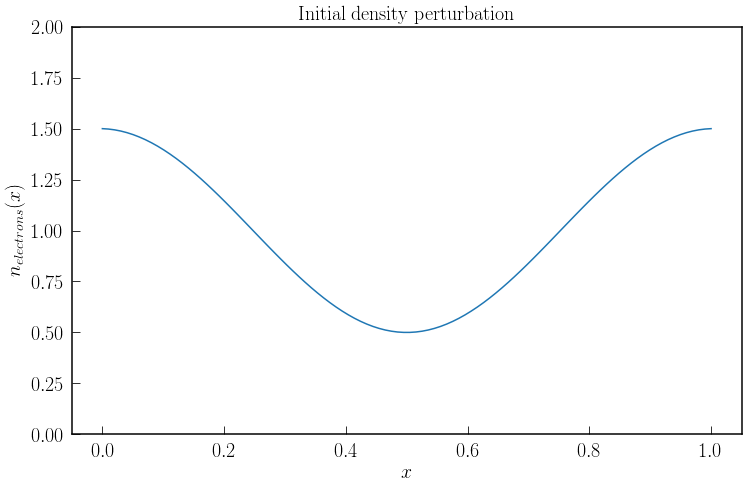

In [17]:
# Plotting the initial density perturbation
pl.plot(position_grid, number_density, label = r'$n$')
pl.title(r'$\mathrm{Initial\;density\;perturbation}$')
pl.xlabel('$x$')
pl.ylabel(r'$n_{electrons}(x)$')
pl.ylim(0.0,2.0)
pl.show()
pl.clf()

In [18]:
# Time parameters
start_time = 0

end_time   = 3

dt         = 0.002

time       = np.arange(    start_time,\
                           end_time + dt,\
                           dt,\
                           dtype = np.double\
                      )

In [19]:
# Some variables for storing data
Ex_max       = np.zeros(len(time), dtype = np.double)

In [20]:
# Plotting the initial conditions
# Finding interpolant fractions for the positions
zone_x, frac_x = find_zone_and_fraction(positions_x, x_grid, dx)

# Charge deposition using linear weighting scheme

rho_electrons  = cloud_charge_deposition(charge_electron, zone_x,\
                                         frac_x, x_grid, dx\
                                        )

rho_initial    = norm_background_ions(rho_electrons, number_of_electrons, w_p) 

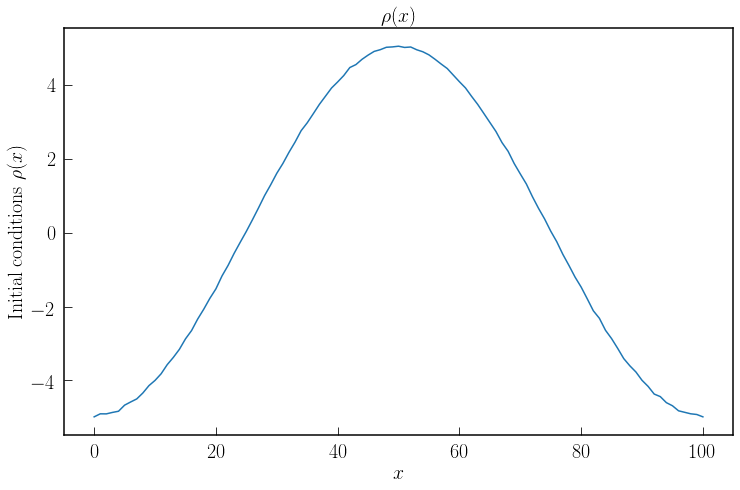

In [21]:
# plotting intial rho in the system considering background ions
pl.plot(rho_initial)
pl.xlabel('$x$')
pl.ylabel(r'$\mathrm{Initial\;conditions}\;\rho(x)$')
pl.title(r'$\rho(x)$')
pl.show()
pl.clf()

In [22]:
# Computing initial potential and electric field
potential_initial, Ex_initial = fft_poisson(rho_initial, dx)

/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


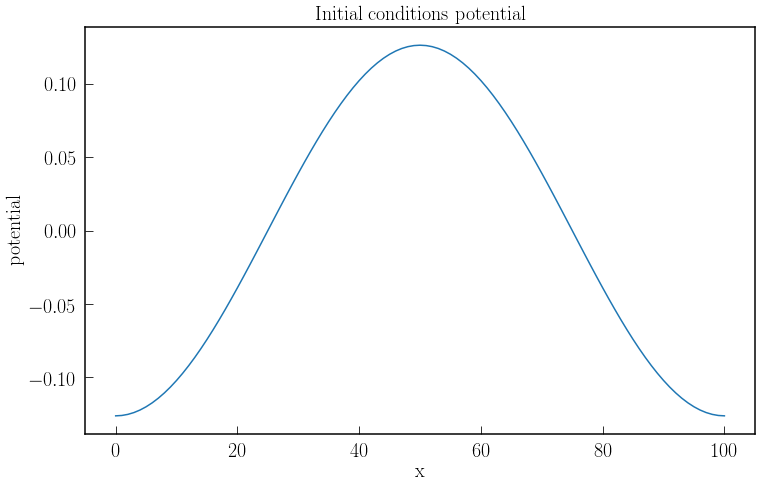

In [23]:
# Plotting the potential for the initial conditions
pl.plot(potential_initial)
pl.xlabel('x')
pl.ylabel('$\mathrm{potential}$')
pl.title('$\mathrm{Initial\;conditions\;potential}$')
pl.show()
pl.clf()

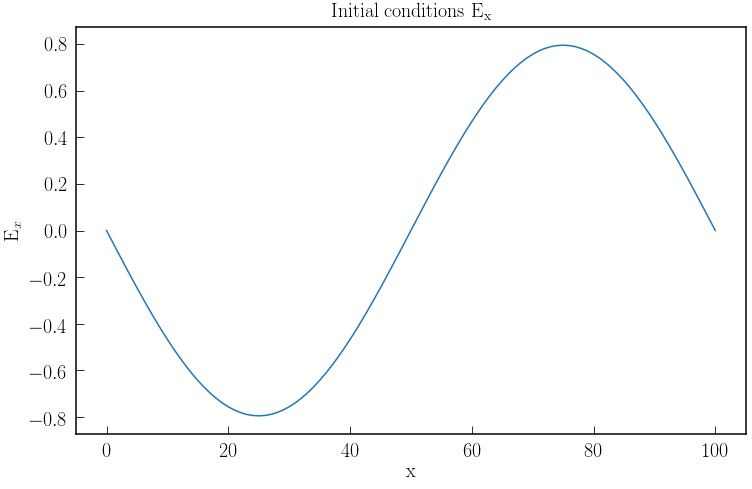

In [24]:
# Plotting the Electric field in the system for the given initial conditions
pl.plot(Ex_initial, label = 'Ex numerical')
pl.xlabel('x')
pl.ylabel('E_{x}')
pl.title('$\mathrm{Initial\;conditions\;E_{x}}$')
pl.show()
pl.clf()

The following cell block determines $v(\frac{\Delta t}{2})$:
\begin{align}
v(\frac{\Delta t}{2}) = v(t = 0) + E_{x}\left(x(\frac{\Delta t}{2})\right)\frac{\Delta t}{2}
\end{align}

In [ ]:
# This cell block is to obtain v at (t = 0.5dt) to implement the verlet algorithm.

positions_x_half = positions_x + velocity_x * dt/2

# Periodic Boundary conditions for particles 

positions_x_half = periodic_particles(positions_x_half, length_domain_x)

# Finding interpolant fractions for the positions
zone_x, frac_x = find_zone_and_fraction(positions_x_half, x_grid, dx)

# Interpolating the fields at each particle

Ex_particle = interpolate.interp1d(x_grid, Ex_initial, kind = 'linear')(positions_x_half)

# Updating the velocity using the interpolated Electric fields to find v at (t = 0.5dt)

velocity_x = velocity_x  + (Ex_particle * charge_electron / mass_electron ) * dt/2
time_grid = np.linspace(0, time[-1], len(Ex_max))

In [ ]:
for time_index in range(len(time)):
    if(time_index%100==0):
        print('Computing for time = ', time_index * dt)

    # Updating the positions of particle using the velocites (Verlet algorithm)
    # velocity at t = (n + 1/2) dt, positions_x at t = (n)dt and positions_x_new 
    # at t = (n+1)dt
    positions_x_new = positions_x + velocity_x * dt
    
    # Periodic Boundary conditions for particles 
    positions_x_new = periodic_particles(positions_x_new, length_domain_x)
    
    # Finding interpolant fractions for the positions
    zone_x, frac_x = find_zone_and_fraction(positions_x_new, x_grid, dx)

    # Charge deposition using linear weighting scheme

    rho_electrons  = cloud_charge_deposition(charge_electron, zone_x, frac_x, x_grid, dx)
    rho_normalized = norm_background_ions(rho_electrons, number_of_electrons, w_p) 

    # Calculating the potential/Electric field from the charge deposition.

    potential, Ex = fft_poisson(rho_normalized,dx)
    
    # Interpolating the fields at each particle
    
    Ex_particle = interpolate.interp1d(x_grid, Ex, kind = 'linear')(positions_x)
    
    pl.plot(x_grid, Ex)
    pl.ylim(-1,1)
    pl.savefig('images/Ex' + str(time_index) + '.png')
    pl.clf()

    # Updating the velocity using the interpolated Electric fields
    
    velocity_x_new = velocity_x  + (Ex_particle * charge_electron / mass_electron ) * dt
    
    # Saving the Electric fields for plotting
    
    Ex_max[time_index]       = max(abs(Ex))

    # Saving the updated velocites for the next timestep
    velocity_x  = velocity_x_new.copy()
    positions_x = positions_x_new.copy()

Computing for time =  0.0


/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Computing for time =  0.2
Computing for time =  0.4
Computing for time =  0.6
Computing for time =  0.8
Computing for time =  1.0


### Comparing the plots from both Linear theory calculations and Electrostatic PIC below

In [ ]:
# Reading data generated by the Cheng Knorr code
h5f = h5py.File('CK_256.h5', 'r')
Ex_max_CK = h5f['max_E'][:]
Ex_max_CK = np.abs(Ex_max_CK)
h5f.close()
time_CK = np.linspace(0,3, len(Ex_max_CK))

In [ ]:
# Reading data generated by the Cheng Knorr code
h5f = h5py.File('LT.h5', 'r')
Ex_max_LT = h5f['Ex_amp'][:]
Ex_max_LT = np.abs(Ex_max_LT)
time_LT   = h5f['time_LT'][:]
h5f.close()

In [ ]:
time_grid = np.linspace(0, time[-1], len(Ex_max))
pl.plot(time_grid, Ex_max , label = r'$\mathrm{PIC}$')
# pl.plot(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.plot(time_CK, Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
# print('(abs(Ex_amplitude[0])) is ',(abs(Ex_amplitude[0])))
# print('(abs(Ex_max[0])) is ',(abs(Ex_max[0])))
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
pl.legend()
# pl.show()
# pl.savefig('MaxE_LT.png')
pl.clf()

In [ ]:
pl.semilogy(time_grid, Ex_max ,label = r'$\mathrm{PIC}$')
# pl.semilogy(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.semilogy(time_CK,Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
pl.legend()
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
# pl.show()
# pl.savefig('MaxE_semilogy_LT.png')
pl.clf()

In [ ]:
pl.loglog(time_grid, Ex_max ,label = r'$\mathrm{PIC}$')
# pl.loglog(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.semilogy(time_CK,Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
pl.legend()
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
# pl.show()
# pl.savefig('MaxE_loglog_LT.png')
pl.clf()